# d2spike: Tutorial 2

## Detailed look at despiking a 1D series of mostly good data

Data is from a Nortek Vector measuring real wave-induced flow (in a flow tank) at high freqeuncy. 

In [1]:
import numpy as np
import xarray as xr
from d2spike.despike import D2spikearray
import d2spike as d2s
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('../assets/T0070_ds_vec1.nc')
print(np.diff(ds.time.values)[0] / np.timedelta64(1,'ms'))
ds

39.999961


<xarray.Dataset>
Dimensions:              (station: 1, x1: 4, x2: 4, time: 29475, dir: 4, beam: 4)
Coordinates: (12/14)
  * station              (station) object 'VEC1'
  * x1                   (x1) int32 1 2 3 4
  * x2                   (x2) int32 1 2 3 4
  * time                 (time) datetime64[ns] 2023-11-07T09:12:58.418000 ......
  * dir                  (dir) object 'X' 'Y' 'Z1' 'Z2'
  * beam                 (beam) int32 1 2 3 4
    ...                   ...
    station_z            (station) float64 ...
    station_zbed         (station) float64 ...
    station_ID           (station) object ...
    station_h            (station) float64 ...
    time_utc             (time) datetime64[ns] ...
    time_offset          (time) float64 ...
Data variables:
    beam2inst_orientmat  (station, x1, x2) float64 ...
    status               (station, time) uint8 ...
    vel                  (station, dir, time) float32 ...
    amp                  (station, beam, time) uint8 ...
    corr                 (station, beam, time) uint8 ...
Attributes: (12/60)
    inst_make:                   Nortek
    inst_model:                  Vectrino
    inst_type:                   ADV
    rotate_vars:                 vel
    n_beams:                     4
    profile_mode:                continuous
    ...                          ...
    QGHL_test_metadata:          {'QGHL_test': 'QGHL test ID', 'UWA_test': 'U...
    ADV_orientation:             downward looking; beam 1: positive-x;beam 2:...
    Description:                 Vectrino point ADV data
    Raw files path:              ../Documents - RES-ARC_LP_UWA_QGHL/General/U...
    Raw files:                   T0070UWAT128Hs100Tp224h450G116D1119_VEC1_202...
    Xarray dataset date:         2024-02-20T19:18:30.615088

### View the data in 1D

Look at the  whole dataset and a small portion. 

Remember `.floatda` is used to access the d2spike functions via xarray.

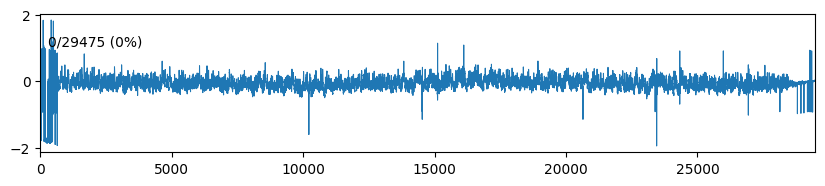

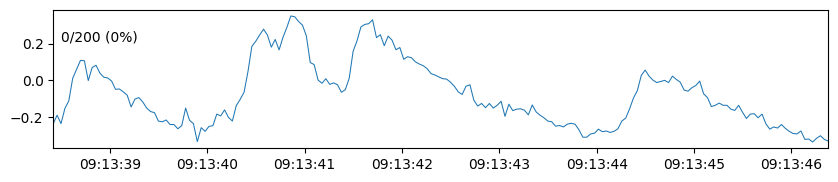

In [3]:
# Initialise the d2spike object (this can also be initialised by calling any of the non-plotting methods)
y_da = ds['vel'].isel(dir=0, station=0).copy()

# Plot the data (returns: fig,ax)
_=y_da.floatda.plot_uts()
_=y_da[1000:1200].floatda.plot_uts(index=False) # Can call to xarray and back to d2spike to use that functionality.

We weren't expecting flows at $\pm$ 2 m s $^{-1}$ in a flow tank. Early data is clearly bad. For a better option we can look at the data vs. correlation which is supplied by the instrument. 

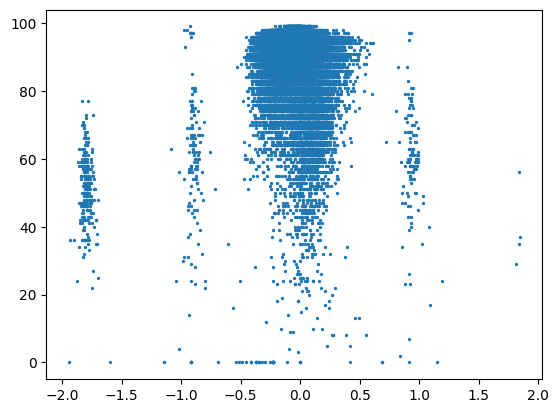

In [4]:
# We are using the estimated u1 data, which was compiled from 3 beams, so we will take the min value across beams. 
y_corr = ds['corr'].isel(station=0).min(dim='beam')

plt.scatter(y_da.values, y_corr.values, s=2)

It's pretty clear that the values at around $\pm$ 1 and $\pm$ 2 m s $^{-1}$ are not part of the main data cloud. These are probably phase-wrapping or some other spike form.

We can use correlation and a max value flag to remove this bad data before despiking. We will only remove correlation values below 3200, which won't do much.



### Remove any low correlation data or unphysical values (optional steps)

If the instrument supplies a supplementary measure of data quality, such as correlation, that can be used to weed out likely bad data. 

Obviously unphysical values can be removed as well.

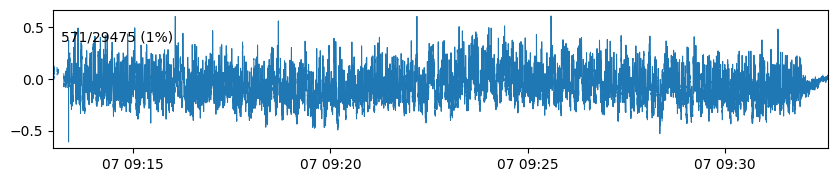

In [5]:
# Create a new variable so we can compare to y_da later
y_fl = y_da.floatda.qc0_flags(val=0.7)
y_fl = y_fl.floatda.qc0_lowcorr(y_corr, 20)
_=y_fl.floatda.plot_uts(index=False, bars=False)

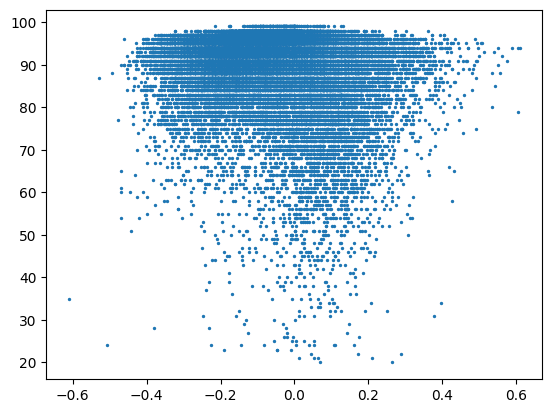

In [6]:
plt.scatter(y_fl.values, y_corr.values, s=2)

This looks more like real data now. We can proceed to background removal and despiking.

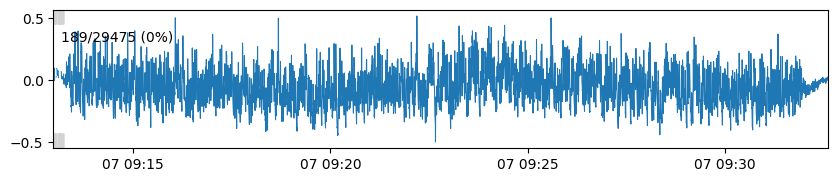

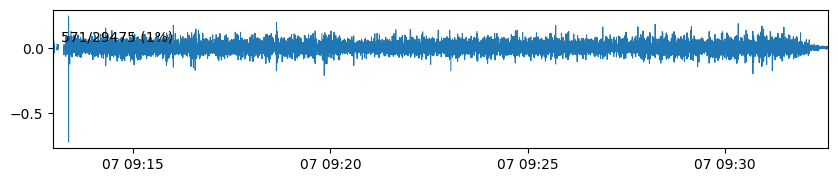

In [21]:
y_lp = y_fl.floatda.gaussian_filter(2)
y_hp = y_fl - y_lp

_=y_lp.floatda.plot_uts(index=False)
_=y_hp.floatda.plot_uts(index=False, bars=False)

Now we can run the despike on the high frequency component. 

SW stat: 0.985, p value: 0.0
SW stat: 0.988, p value: 0.0
SW stat: 0.989, p value: 0.0
11


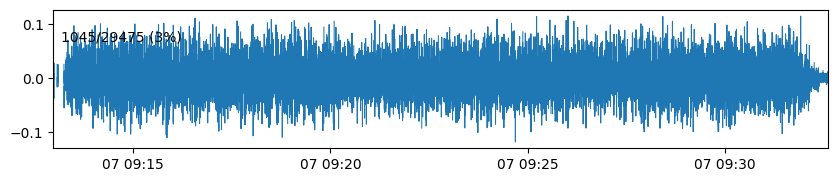

In [22]:
w_gn, t_full = y_hp.floatda.despike_gn23(full_output=True)
_=w_gn.floatda.plot_uts(index=False, bars=False)

This looks good now, there was 11 iterations until the data converged sufficiently. A more stringent despiking can be implemented by raising the sw_thresh higher than the default of 0.98. We can have a more detailed look at what happened. 

SW stat: 0.985, p value: 0.0
SW stat: 0.988, p value: 0.0
SW stat: 0.989, p value: 0.0


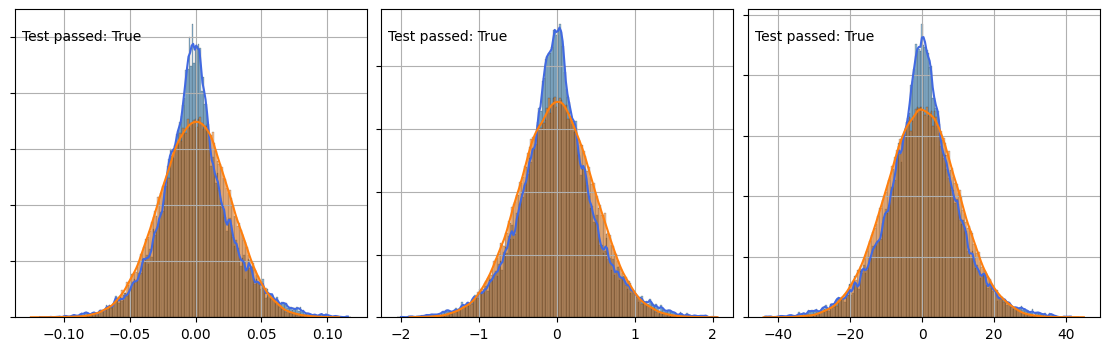

In [23]:
_=w_gn.floatda.plot_marginals()

Blue is our data across the 3 distributions which are assumed normal (the high-frequency data, the first derivative, and the second derivative). The orange is from a true normal distribution. 

We can also look at the ellipses of each pair. 

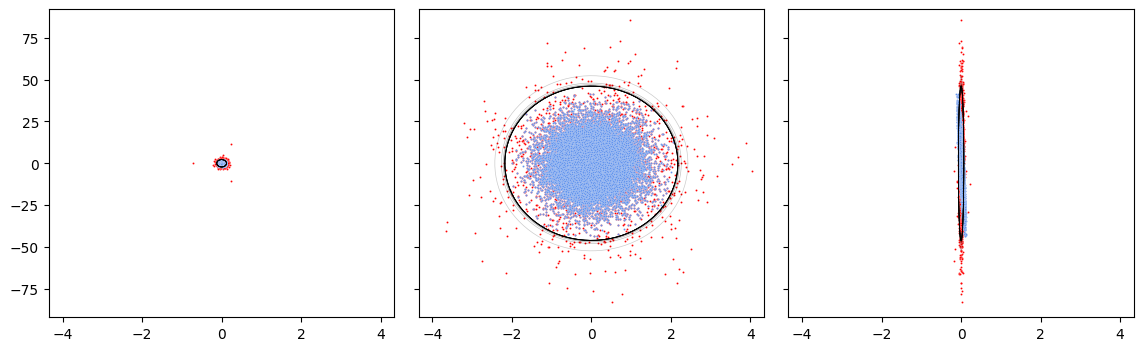

In [24]:
_=w_gn.floatda.plot_ellipses(t_full)

Finally we can look at how the spikes were applied.

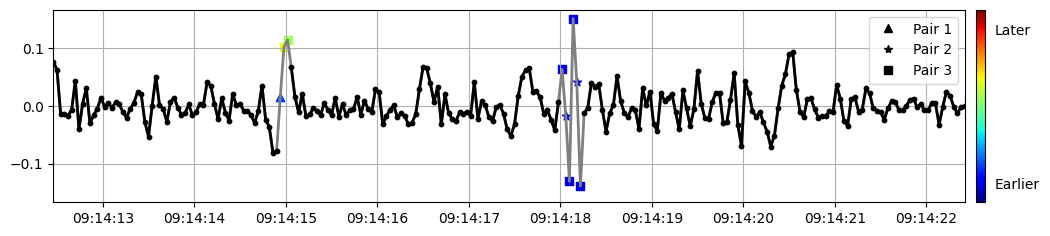

In [25]:
_=w_gn.floatda.plot_explore_flags(t_full, indexes=[1850,2100])

Goring-Nikora removes too many data points - the 'shoulders' of the spikes are removed as well.

Let's find them and put them back.

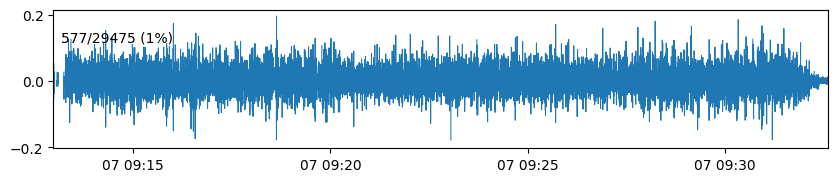

In [26]:
# indexing reinstatement
re_ix = np.abs(y_hp) < 0.2
w_gn = w_gn.floatda.reinstate_threshold(y_hp, re_ix)
_=w_gn.floatda.plot_uts(index=False, bars=False)

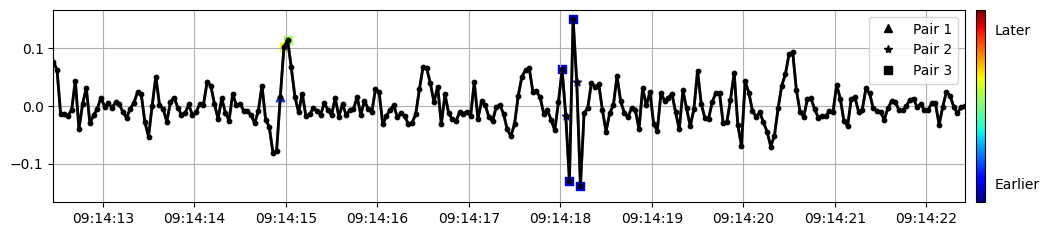

In [27]:
_=w_gn.floatda.plot_explore_flags(t_full, indexes=[1850,2100])

(<Figure size 1000x180 with 1 Axes>, <Axes: >)

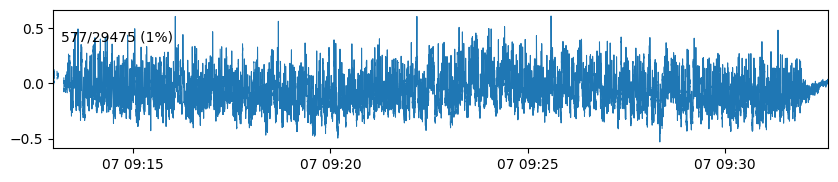

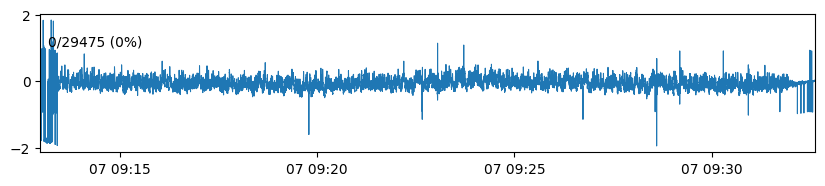

In [28]:
fig, ax = (w_gn + y_lp).floatda.plot_uts(index=False, bars=False)
ds['vel'].isel(dir=0, station=0).floatda.plot_uts(index=False, bars=False)

The early bad data may have thrown off our statistical analysis. Let's run it again to check if it thinks there are still spikes.

SW stat: 0.986, p value: 0.0
SW stat: 0.989, p value: 0.0
SW stat: 0.989, p value: 0.0
20


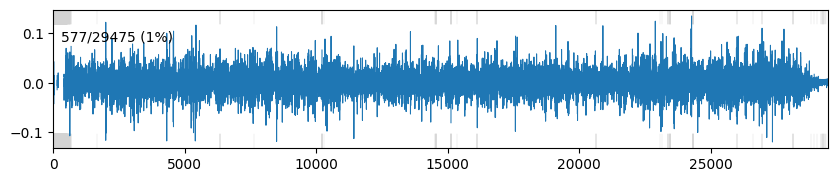

In [51]:
y_da2 = (w_gn + y_lp).copy()
y_lp2 = y_da2.floatda.gaussian_filter(1)
y_hp2 = y_da2 - y_lp2

w_gn2, t2_full = y_hp2.floatda.despike_gn23(full_output=True)
re_ix = np.abs(y_hp2) < 0.15
w_gn2 = w_gn2.floatda.reinstate_threshold(y_hp2, re_ix)

fig, ax = w_gn2.floatda.plot_uts()
# fig, ax = (w_gn2 + y_lp2).floatda.plot_uts(index=False, bars=False)

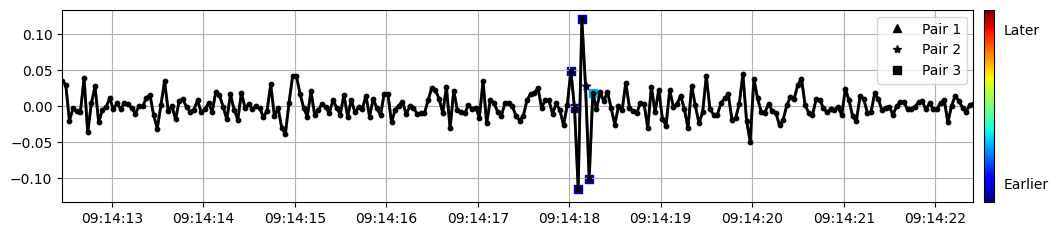

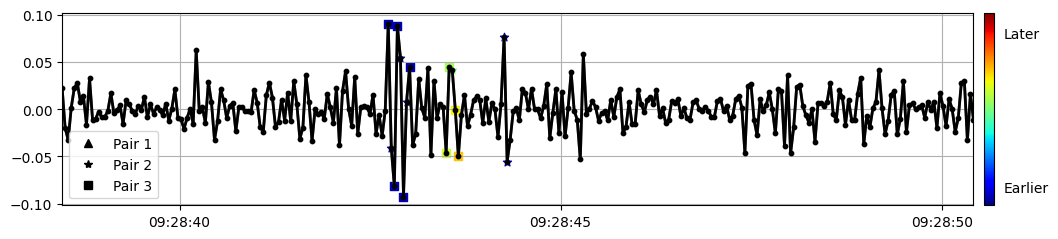

In [52]:
_=w_gn2.floatda.plot_explore_flags(t2_full, indexes=[1850,2100])
_=w_gn2.floatda.plot_explore_flags(t2_full, indexes=[23500,23800])

We have left the reinstatement value fairly high (0.15), because these events appear real (they have data at intermediate points along the way). If we set it low (e.g. 0.025) we would lose these events. It's up to the user to determine. 

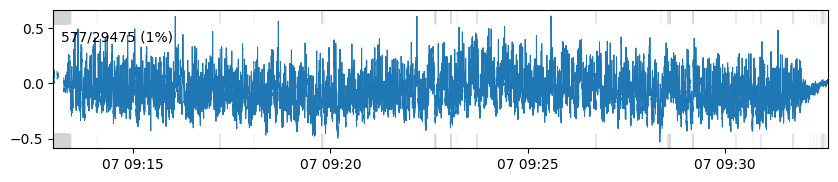

In [53]:
fig, ax = (w_gn2 + y_lp2).floatda.plot_uts(index=False)